In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('PRate.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
targetf = pd.read_csv('dataset_rel.csv')
targetf.index = pd.to_datetime(targetf['Date'])

In [4]:
targetf

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,RateFactor1
Date,,,,,,,,,
2002-01-03,0.0050,0.0150,-0.00250,-0.01000,-0.0100,-0.0110,-0.0160,2002-01-03,0.805552
2002-02-07,0.0125,0.0100,0.01500,0.02750,0.0250,0.0250,0.0095,2002-02-07,0.816128
2002-03-07,-0.0025,0.0100,0.00500,0.01000,0.0125,0.0015,-0.0020,2002-03-07,-0.107034
2002-04-04,0.0000,0.0050,0.00500,0.00000,0.0050,-0.0025,-0.0015,2002-04-04,0.033911
2002-05-02,0.0100,0.0000,0.00500,0.00450,0.0000,0.0035,0.0030,2002-05-02,0.582898
...,...,...,...,...,...,...,...,...,...
2018-03-08,0.0000,0.0041,-0.00035,0.00035,0.0057,0.0164,0.0099,2018-03-08,-0.128477
2018-04-26,0.0000,-0.0010,0.00000,0.00000,-0.0020,-0.0030,-0.0020,2018-04-26,-0.184312
2018-06-14,0.0000,0.0000,-0.00100,-0.00750,-0.0250,-0.0495,-0.0370,2018-06-14,0.194824


In [6]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
pcdf = pd.concat([pcdf, targetf], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])

# transform data into means

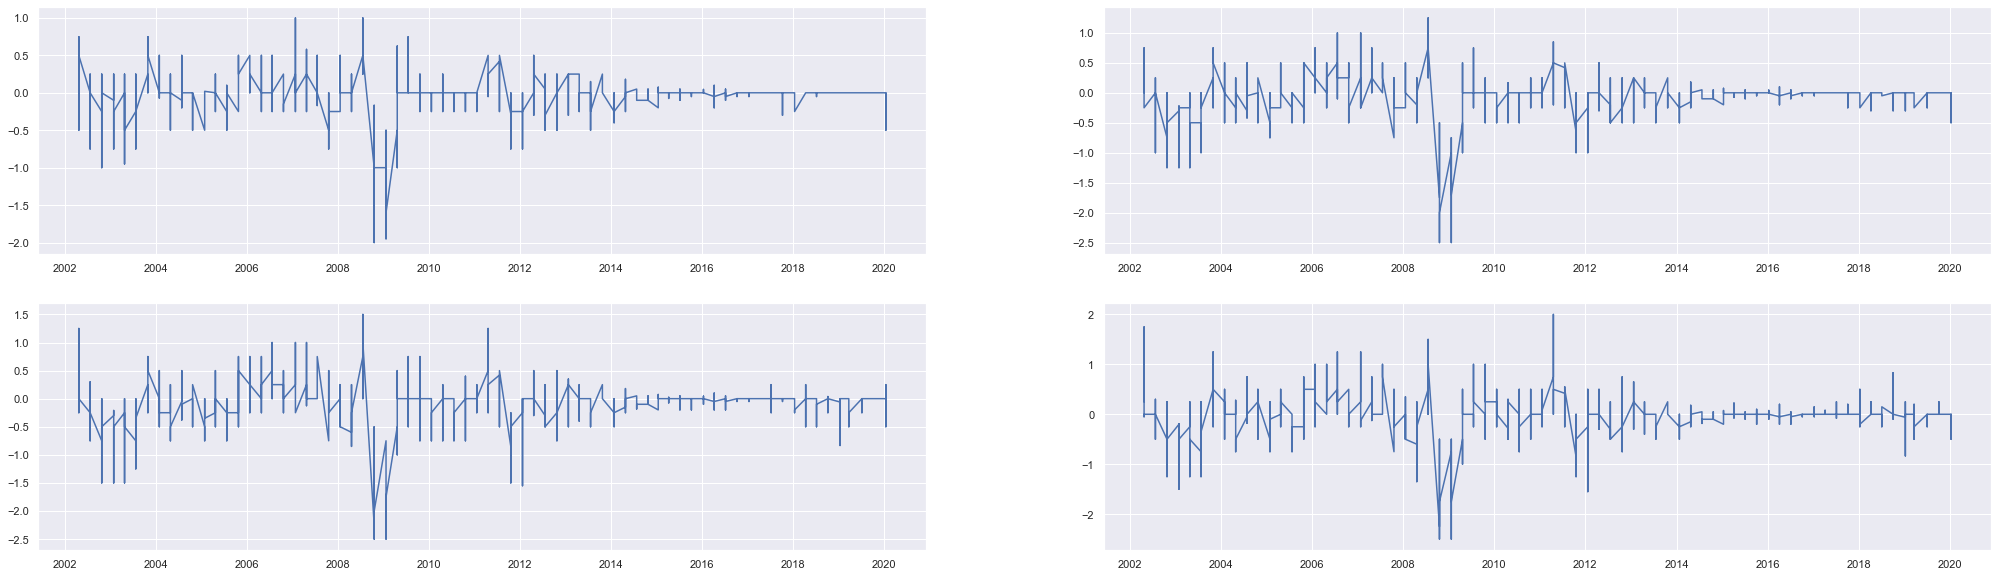

In [7]:
df_gdp = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
df_gdp['CurrentIR'] = df_gdp['CurrentIR'].astype(float)
df_gdp['IRQ1'] = df_gdp['IRQ1'].astype(float)
df_gdp['IRQ2'] = df_gdp['IRQ2'].astype(float)
df_gdp['IRQ3'] = df_gdp['IRQ3'].astype(float)
df_gdp['IRQ1_L'] = df_gdp['IRQ1'].shift(1).astype(float)
df_gdp['IRQ2_L'] = df_gdp['IRQ2'].shift(1).astype(float)
df_gdp['IRQ3_L'] = df_gdp['IRQ3'].shift(1).astype(float)
dfgdp1 = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
dfgdp1['diffCurrentIR'] = dfgdp1['CurrentIR'] - dfgdp1['IRQ1_L']
dfgdp1['diffIRQ1'] = dfgdp1['IRQ1'] - dfgdp1['IRQ2_L']
dfgdp1['diffIRQ2'] = dfgdp1['IRQ2'] - dfgdp1['IRQ3_L']
dfgdp1['diffIRQ3'] = dfgdp1['IRQ3'].diff()
dfgdp1 = dfgdp1.sort_index()

fig, axs = plt.subplots(2, 2, figsize=(35, 10));
axs[0,0].plot(dfgdp1['diffCurrentIR'].dropna().astype(float))
axs[0,1].plot(dfgdp1['diffIRQ1'].dropna().astype(float))
axs[1,0].plot(dfgdp1['diffIRQ2'].dropna().astype(float))
axs[1,1].plot(dfgdp1['diffIRQ3'].dropna().astype(float));

In [8]:
dfgdp1.iloc[200:,:]

,Source,CurrentIR,IRQ1,IRQ2,IRQ3,IRQ4,IRQ1_L,IRQ2_L,IRQ3_L,diffCurrentIR,diffIRQ1,diffIRQ2,diffIRQ3
SurveyDate,,,,,,,,,,,,,
1999-05-03,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-03,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-03,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-03,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-03,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-13,90,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,91,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


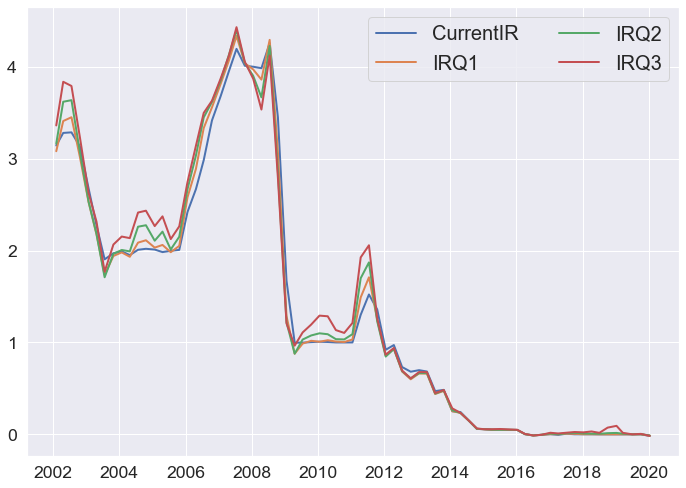

In [15]:
#df1gdpmeans = dfgdp1.groupby('SurveyDate')[[ 'diffCurrentIR',
#       'diffIRQ1', 'diffIRQ2', 'diffIRQ3']].mean()
df1gdpmeans = df_gdp.groupby('SurveyDate')[[ 'CurrentIR',
       'IRQ1', 'IRQ2', 'IRQ3']].mean()

sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans, linewidth=2.0);
plt.legend(list(df1gdpmeans), ncol=2, loc='upper right', fontsize=20);

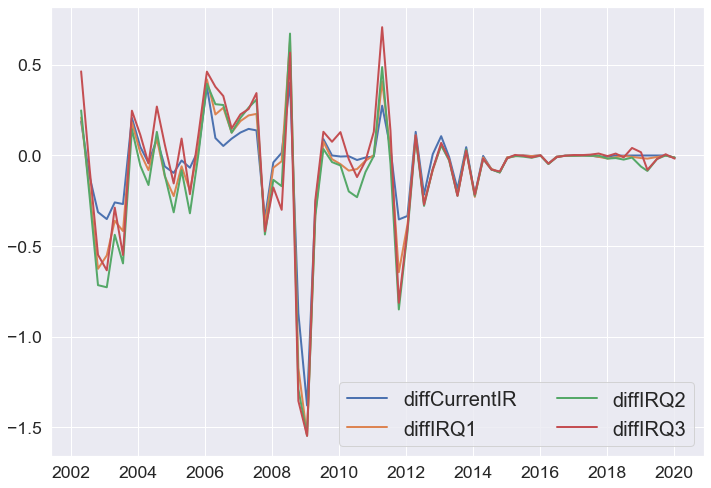

In [10]:
df1gdpmeansnew = dfgdp1.groupby('SurveyDate')[['CurrentIR',
       'IRQ1', 'IRQ2', 'IRQ3']].mean()
df1gdpmeansnew = df1gdpmeansnew.diff()
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(df1gdpmeans, linewidth=2.0);
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20);

In [13]:
df1gdpmeans

,diffCurrentIR,diffIRQ1,diffIRQ2,diffIRQ3
SurveyDate,,,,
1999-02-12,NaN,NaN,NaN,NaN
1999-05-03,NaN,NaN,NaN,NaN
1999-08-06,NaN,NaN,NaN,NaN
1999-11-03,NaN,NaN,NaN,NaN
2000-02-09,NaN,NaN,NaN,NaN
...,...,...,...,...
2019-01-11,0.000000,-0.014286,-0.061270,0.017876
2019-03-22,0.000000,-0.017391,-0.085307,-0.079129
2019-07-05,0.000000,-0.008333,-0.019350,-0.019350


In [16]:
df1gdpmeans['IRQ1_lagged'] = df1gdpmeans['IRQ1'].shift(1)#'CurrentIR'
df1gdpmeans['One Quarter Ahead Revision'] = df1gdpmeans['CurrentIR'] - df1gdpmeans['IRQ1_lagged']
df1gdpmeans['IRQ3_lagged'] = df1gdpmeans['IRQ3'].shift(1)#
df1gdpmeans['Three Quarters Ahead Revision'] = df1gdpmeans['IRQ2'] - df1gdpmeans['IRQ3_lagged']
df1gdpmeans['IRQ2_lagged'] = df1gdpmeans['IRQ2'].shift(1)#
df1gdpmeans['Two Quarters Ahead Revision'] = df1gdpmeans['IRQ1'] - df1gdpmeans['IRQ2_lagged']

In [27]:
##get OLS estimate of the OIS 3Y
#order data

dataols = pd.merge_asof(df1gdpmeans, pcdf, left_index=True, right_index = True,
                       direction='backward')
var = ['RateFactor1','ConfFactor1', 'ConfFactor2', 'ConfFactor3']
#var = ['OIS_1M']
yvar = 'One Quarter Ahead Revision'
dataols[var] = dataols[var].astype(float)
#pp to basic points
dataols[yvar] = dataols[yvar].astype(float)*100
dataols = dataols.dropna(subset = ['RateFactor1', 'ConfFactor1', 'ConfFactor2', 'ConfFactor3', yvar])
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2010-01-01']
X = sm.add_constant(dataols[var])
model = sm.OLS(dataols[yvar], X)
results = model.fit(cov_type = 'HAC', cov_kwds={'maxlags': 4})
print(results.summary())

                                OLS Regression Results                                
Dep. Variable:     One Quarter Ahead Revision   R-squared:                       0.373
Model:                                    OLS   Adj. R-squared:                  0.312
Method:                         Least Squares   F-statistic:                     2.072
Date:                        Sat, 14 Nov 2020   Prob (F-statistic):              0.102
Time:                                22:33:51   Log-Likelihood:                -206.06
No. Observations:                          46   AIC:                             422.1
Df Residuals:                              41   BIC:                             431.3
Df Model:                                   4                                         
Covariance Type:                          HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [26]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(results.tvalues, results.params )

,0
-9.17,nan
1.41,nan
-9.58,nan
-2.29,nan
7.08,nan


In [82]:
##get OLS estimate of the OIS 3Y
#order data

dataols = pd.merge_asof(df1gdpmeans, pcdf, left_index=True, right_index = True,
                       direction='backward')
var = ['RateFactor1','ConfFactor1', 'ConfFactor2', 'ConfFactor3']
#var = ['OIS_1M']
yvar = 'diffIRQ1'
dataols[var] = dataols[var].astype(float)
#pp to basic points
dataols[yvar] = dataols[yvar].astype(float)*100
dataols['d_neg'] = 0
dataols.loc[dataols['ConfFactor1'] < 0, 'd_neg'] = 1
dataols['d_neg'] = dataols['ConfFactor1']*dataols['d_neg']
var = ['ConfFactor1',  'd_neg']
dataols = dataols.dropna(subset = ['RateFactor1', 'ConfFactor1', 'ConfFactor2', 'ConfFactor3', yvar])
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2010-01-01']
X = sm.add_constant(dataols[var])
model = sm.OLS(dataols[yvar], X)
results = model.fit(cov_type = 'HAC', cov_kwds={'maxlags': 4})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               diffIRQ1   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     15.16
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.04e-05
Time:                        00:55:30   Log-Likelihood:                -220.30
No. Observations:                  46   AIC:                             446.6
Df Residuals:                      43   BIC:                             452.1
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5105      4.937      0.509      

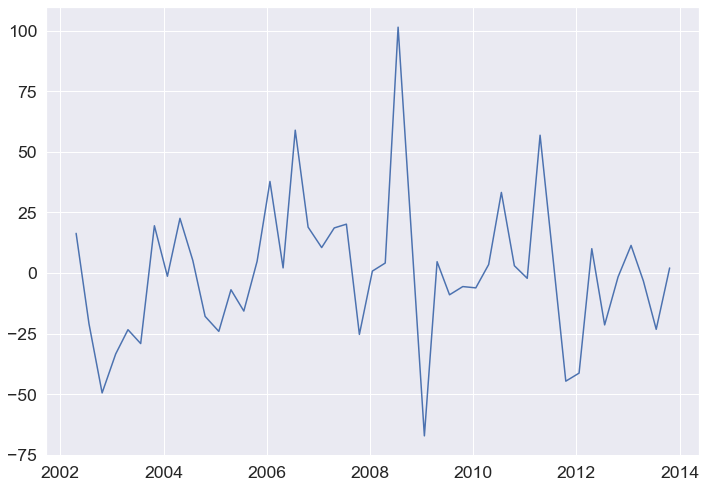

In [72]:
plt.plot(results.resid)

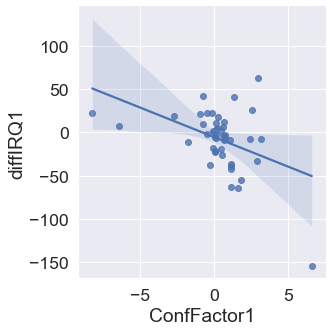

In [74]:
sns.lmplot(x = 'ConfFactor1', y = 'diffIRQ1', data = dataols);

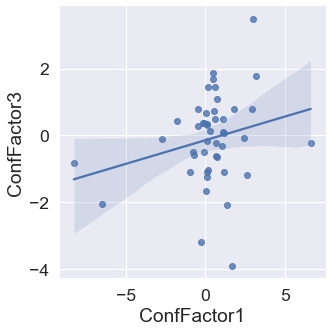

In [13]:
sns.lmplot(x = 'ConfFactor1', y = 'ConfFactor3', data = dataols);

In [14]:
dataols['RateFactor1'].corr(dataols['ConfFactor3'])

-0.3050812735762343

In [15]:
import scipy

In [16]:
scipy.stats.pearsonr(dataols['RateFactor1'], dataols['ConfFactor3'])

(-0.3050812735762344, 0.03924077703825079)

In [17]:
pcdf = pcdf.dropna(subset=['RateFactor1', 'ConfFactor1'])
scipy.stats.pearsonr(pcdf['RateFactor1'], pcdf['ConfFactor3'])

(0.004037010107526606, 0.9571064136846895)

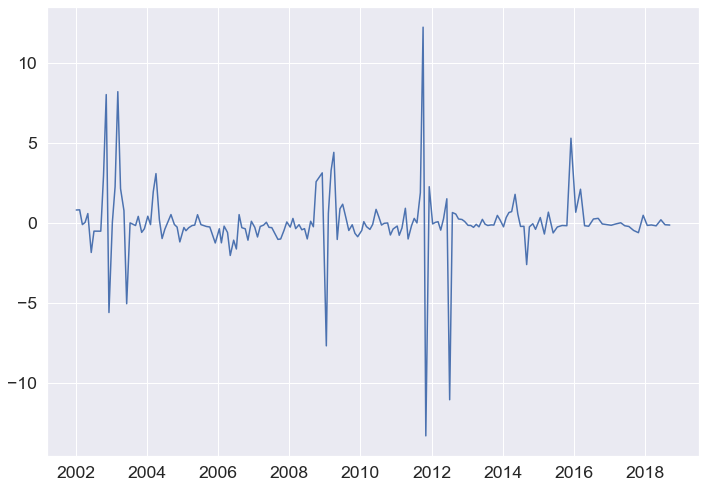

In [18]:
plt.plot(pcdf['RateFactor1'])